In [1]:
import os
import sys
import json
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt
from IPython.display import Image

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFEM import DiffNet2DFEM

from DiffNet.datasets.parametric.images import ImageIMBack
from e1_complex_immersed_background import Poisson, MyPrintingCallback
from torch.utils.data import DataLoader

Global seed set to 42
Global seed set to 42


In [2]:
case_dir = './cib/version_1'
query_inp_path = './cib/version_1/query-inputs' # can be any directory containing only the test images, no other files
query_out_path = './cib/version_1/query-outputs'
if not os.path.exists(query_out_path):
    os.makedirs(query_out_path)

In [3]:
batch_size = 16
dataset = ImageIMBack(query_inp_path, domain_size=256)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
#network = GoodNetwork(in_channels=2, out_channels=1, in_dim=64, out_dim=64)
network = torch.load(os.path.join(case_dir, 'network.pt'))
basecase = Poisson(network, batch_size=batch_size, domain_size=256)

logger = pl.loggers.TensorBoardLogger('.', name="cib")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
        min_delta=1e-8, patience=50, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)
printsave = MyPrintingCallback()

trainer = pl.Trainer(accelerator='gpu',devices=1,
                     callbacks=[early_stopping,checkpoint,printsave],
                     logger=[logger,csv_logger], 
                     max_epochs=150,
                     fast_dev_run=False
                     )

nsample = len(dataloader.dataset)
print("nsample = ", nsample)

/work/mech-ai/bkhara/python_virtual_envs/lightning/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /work/mech-ai/bkhara/python_virtual_envs/lightning/ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


nsample =  3


In [4]:
basecase.network.eval()
for i in range(nsample//10+1):
    id0 = 10*i
    id1 = id0+10
    if id1 > nsample:
        id1 = nsample
        
    # core query code
    if id0 < id1:
        inputs, forcing = dataloader.dataset[id0:id1]
        nu_par_list, f_par_list, u_par_list = printsave.do_query(trainer, basecase, inputs, forcing)

0


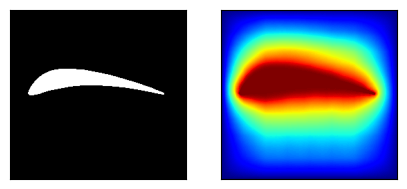

1


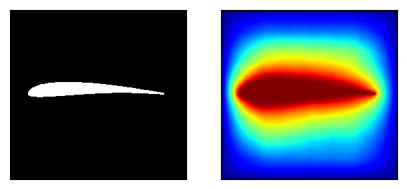

2


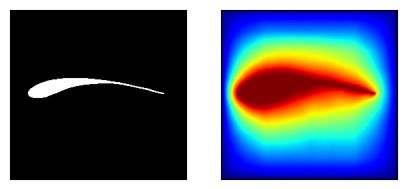

In [5]:
for i in range(nsample):
    print(i)
    # core query code
    nu = nu_par_list[i]
    u_par = u_par_list[i]
    
    # plotting
    num_query = 1
    plt_num_row = num_query
    plt_num_col = 2
    fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2.5*plt_num_col,2.2*plt_num_row),
                        subplot_kw={'aspect': 'auto'}, sharex=True, sharey=False, squeeze=True)
    for j in range(plt_num_col):
            axs[j].set_xticks([])
            axs[j].set_yticks([])

    for idx in range(num_query):
        # extract diffusivity and boundary conditions here
        im0 = axs[0].imshow(nu,cmap='gray_r',aspect="auto")
        # cb = fig.colorbar(im0, ax=axs[0], fraction=0.04, pad=0.1,orientation="horizontal")

        im1 = axs[1].imshow(u_par,cmap='jet',aspect="auto")
        # fig.colorbar(im1, ax=axs[1]) 
        # fig.colorbar(im1, ax=axs[1], fraction=0.04, pad=0.1,orientation="horizontal") 
    plt.savefig(os.path.join(query_out_path,'q_'+str(i)+'.pdf'))
    plt.show()
    plt.close('all')